#### (4) Now experiment with different service rate distributions. On the one hand try the M/D/1 and M/D/n queues, on the other hand try a long-tail distribution. For the latter you may e.g. use a distribution where 75% of the jobs have an exponential distribution with an average service time of 1.0 and the remaining 25% an exponential distribution with an average service time of 5.0 (an example of a hyperexponential distribution).

In [1]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

**M/D/1 and M/D/n queues**

In [2]:
def customer(env, mu, counter, waiting):
    # Time of customer arrival
    arrival = env.now
    
    # Wait until customer can get serviced
    with counter.request() as req:
        yield req
        # Add waiting time
        waiting.append(env.now - arrival)
        
        # Time for service
        time = 1 / mu
        
        # Update time
        yield env.timeout(time)
    

In [3]:
def source(env, number, arrival, capacity, counter, waiting):
    # Creating customers
    for i in range(number):
        # Create the customer
        c = customer(env, capacity, counter, waiting)
        env.process(c)
        
        # Time for new person to arrive
        t = np.random.exponential(1 / arrival)
        
        # Update time
        yield env.timeout(t)  

In [4]:
# Parameters
customers = 100000
mu = 1
rho = 0.9
n = 1
arrival = rho * n * mu
print(f'lambda = {arrival}')
print(f'mu = {mu}')

# Array for waiting time
waiting = []

# Create environment
env = simpy.Environment()
np.random.seed(42)
# Create process
counter = simpy.Resource(env, capacity=n)
env.process(source(env, customers, arrival, mu, counter, waiting))
env.run()


lambda = 0.9
mu = 1


In [5]:
# Get mean and standard deviation
waiting_mean = np.mean(waiting)
waiting_std = np.std(waiting, ddof=1)

# Get confidence interval
waiting_conf = 1.96 * waiting_std / np.sqrt(len(waiting))

# Print result
print(f'{waiting_mean} +- {waiting_conf}')

4.512588532182379 +- 0.028399982107603083


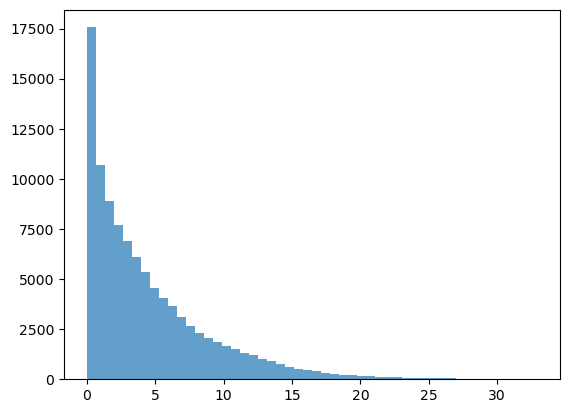

In [6]:
plt.hist(waiting, bins=50, alpha=0.7)
plt.show()

**Service rate with a long-tail distribution**

In [7]:
def customer(env, mu, p, counter, waiting):
    # Time of customer arrival
    arrival = env.now
    
    # Wait until customer can get serviced
    with counter.request() as req:
        yield req
        # Add waiting time
        waiting.append(env.now - arrival)
        
        # Time for service
        if np.random.uniform() < p:
            time = np.random.exponential(1/mu[0])
        else:
            time = np.random.exponential(1/mu[1])
        # Update time
        yield env.timeout(time)
    

In [8]:
def source(env, number, arrival, capacity, p, counter, waiting):
    # Creating customers
    for i in range(number):
        # Create the customer
        c = customer(env, capacity, p, counter, waiting)
        env.process(c)
        
        # Time for new person to arrive
        t = np.random.exponential(1 / arrival)
        
        # Update time
        yield env.timeout(t)  

In [9]:
# Parameters
customers = 100000
mu = [1., 1/5]
p = 0.75
rho = 0.9
n = 1
arrival = rho * n * (0.75 * mu[0] + 0.25 * mu[1])
print(f'lambda = {arrival}')
print(f'mu = {mu}')

# Array for waiting time
waiting = []

# Create environment
env = simpy.Environment()
np.random.seed(42)
# Create process
counter = simpy.Resource(env, capacity=n)
env.process(source(env, customers, arrival, mu, p, counter, waiting))
env.run()


lambda = 0.7200000000000001
mu = [1.0, 0.2]


In [10]:
# Get mean and standard deviation
waiting_mean = np.mean(waiting)
waiting_std = np.std(waiting, ddof=1)

# Get confidence interval
waiting_conf = 1.96 * waiting_std / np.sqrt(len(waiting))

# Print result
print(f'{waiting_mean} +- {waiting_conf}')

30258.59599363739 +- 110.60420970494698


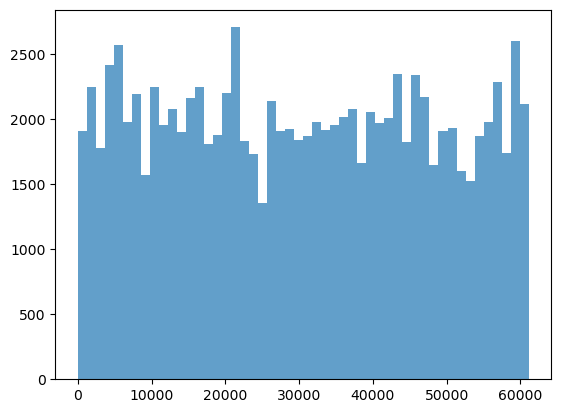

In [11]:
plt.hist(waiting, bins=50, alpha=0.7)
plt.show()

When service times follow a long-tail distribution, a phenomenon may arise where the average waiting time increases with the total number of customers, even if the overall system load $\rho$ is less than one. This occurrence is primarily attributable to the characteristics of the long-tail distribution.

#### Characteristics of Long-Tail Distribution
A long-tail distribution, especially in the context of service times, implies that while most services might be relatively brief, a significant portion of them could be exceedingly lengthy. This distribution is characterized by high variance, indicating substantial fluctuations in service times.

In the given example, 75% of service times follow an exponential distribution with $\lambda=1$, while 25% follow an exponential distribution with $\lambda=0.2$. The latter's average service time is five times that of the former, signifying that a considerable number of service instances will occupy an extensive amount of time.

#### Scenario with System Load Less Than 1
Even with an overall system load less than one, the long-tail distribution of service times can lead to queue instability and increased waiting times due to:

- **Occasional Extended Service Times**: Infrequent occurrences of prolonged service times can lead to sudden queue build-ups, despite the service rate being adequate to handle incoming customers most of the time.

- **High Variance and Unpredictability**: The long-tail distribution heightens the unpredictability of service times, potentially leading to unexpectedly high waiting times even under seemingly "safe" average load levels.

- **Instantaneous Load Exceeding 1**: Although the average load may be less than one, specific instances of prolonged service times can result in instantaneous loads exceeding one, rapidly escalating queue lengths.

#### Conclusion
Consequently, under circumstances where service times adhere to a long-tail distribution, average waiting times may increase with the total number of customers, even if the average load is less than one. This underscores the necessity of considering the characteristics of service time distributions in the design and management of such systems, rather than solely focusing on the average service rate. In practical applications, additional measures, such as augmenting service capacity or introducing priority rules, might be required to mitigate the effects of the long-tail distribution.